1d spatial pde

u_t = alpha *u_xx

Recover alpha + predict u_t

In [62]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [63]:
#params
L = 1.0
alpha = 0.1
Q = 2.0
a = 0
b = 0
N_modes = 100

xs = np.linspace(0, L, 200)
ts = np.linspace(0, 0.5, 100)

#steady state u_s(x)
def u_s(x):
    C2 = a
    C1 = (b-a + (Q/(2*alpha))*L**2)/L
    return -Q/(2*alpha)*x**2 + C1*x + C2

#initial conditions, gaussian bump + steady state
u0 = u_s(xs) + 0.5*np.exp(-((xs-0.4)**2)/(2*(0.05**2)))

#b_n coefficients
b_n = np.zeros(N_modes)
for n in range(1, N_modes+1):
    phi = np.sin(n*np.pi*xs/L)
    integrand = (u0 - u_s(xs)) * phi
    b_n[n-1] = 2.0/L * np.trapezoid(integrand, xs)

def u_xt(x,t):
    s = u_s(x)
    for n in range(1, N_modes+1):
        s+= b_n[n-1]*np.sin(n*np.pi*x/L)*np.exp(-alpha*(n*np.pi/L)**2 * t)
    return s

#get U(x, t)
U = np.zeros((len(xs), len(ts)))
for i, x in enumerate(xs):
    U[i, :] = u_xt(x, ts)

# np.random.seed(0)
noise_level = 0.20
U_noisy = U + noise_level*np.random.randn(*U.shape)*np.abs(U)

#tensors
X, T = np.meshgrid(xs, ts, indexing='ij')
x_data_tensor = torch.tensor(X.flatten(), dtype=torch.float32).view(-1,1)
t_data_tensor = torch.tensor(T.flatten(), dtype=torch.float32).view(-1,1)
U_data_tensor = torch.tensor(U_noisy.flatten(), dtype=torch.float32).view(-1,1)

#IC
x_ic_tensor = torch.tensor(xs, dtype=torch.float32).view(-1,1)
t_ic_tensor = torch.zeros_like(x_ic_tensor)
u_ic_tensor = torch.tensor(u0, dtype=torch.float32).view(-1,1)

#BC
t_bc_tensor = torch.tensor(ts, dtype=torch.float32).view(-1,1)


In [64]:

class PINN(nn.Module):
    def __init__(self, n_hidden=20, n_layers=4):
        super().__init__()
        layers = [nn.Linear(2, n_hidden), nn.Tanh()]
        for _ in range(n_layers - 1):
            layers += [nn.Linear(n_hidden, n_hidden), nn.Tanh()]
        layers += [nn.Linear(n_hidden, 1)]
        self.net = nn.Sequential(*layers)

        self.alpha = nn.Parameter(torch.tensor([alpha], dtype=torch.float32))

    def forward(self, x, t):
        XT = torch.cat((x, t), dim=1)
        return self.net(XT)
    
model = PINN()


In [65]:
#Helper, dy/dx
def derivative(y, x):
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

In [66]:
#Loss funcs

def pde_loss(model, x, t):

    t.requires_grad_(True)
    x.requires_grad_(True)

    u_pred = model(x, t)
    du_dt_pred = derivative(u_pred, t)
    du_dx_pred = derivative(u_pred, x)
    du_dxx_pred = derivative(du_dx_pred, x)

    return torch.mean((du_dt_pred - model.alpha * du_dxx_pred)**2)

def data_loss(model, x, t, u_data):
    u_pred = model(x, t)
    return torch.mean((u_pred - u_data)**2)

def ic_loss(model, x_ic, t_ic, u_ic):
    u_pred = model(x_ic, t_ic)
    return torch.mean((u_pred - u_ic) ** 2)

def bc_loss(model, t_bc, L):
    # Right boundary (x=0)
    x_left = torch.zeros_like(t_bc)
    u_pred_left = model(x_left, t_bc)
    loss_left = torch.mean((u_pred_left - a) ** 2)

    # Right boundary (x=L)
    x_right = torch.full_like(t_bc, L)
    u_pred_right = model(x_right, t_bc)
    loss_right = torch.mean((u_pred_right - b) ** 2)

    return loss_left + loss_right

    



In [67]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

lambda_data = 1.0
lambda_pde  = 0
lambda_ic   = 1.0
lambda_bc   = 1.0

num_epochs = 3000
print_every = num_epochs//10


In [68]:
#train
model.train()
for epoch in range(num_epochs):

    optimizer.zero_grad()

    # Compute losses
    l_data = data_loss(model, x_data_tensor, t_data_tensor, U_data_tensor)
    l_pde  = pde_loss(model, x_data_tensor, t_data_tensor)
    l_ic   = ic_loss(model, x_ic_tensor, t_ic_tensor, u_ic_tensor)
    l_bc   = bc_loss(model, t_bc_tensor, L)


    loss = lambda_data * l_data + lambda_pde* l_pde + lambda_ic * l_ic + lambda_bc * l_bc

    # Backprop
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Total Loss = {loss.item():.6f}, "
              f"Data Loss = {l_data.item():.6f}, "
              f"PDE Loss = {l_pde.item():.6f}, "
              f"IC Loss = {l_ic.item():.6f}")

Epoch 300/3000, Total Loss = 0.157563, Data Loss = 0.148050, PDE Loss = 3.943702, IC Loss = 0.008179
Epoch 600/3000, Total Loss = 0.150763, Data Loss = 0.146104, PDE Loss = 5.790472, IC Loss = 0.004431
Epoch 900/3000, Total Loss = 0.148734, Data Loss = 0.145392, PDE Loss = 5.966928, IC Loss = 0.003311
Epoch 1200/3000, Total Loss = 0.147917, Data Loss = 0.145399, PDE Loss = 6.478857, IC Loss = 0.002326
Epoch 1500/3000, Total Loss = 0.146902, Data Loss = 0.145248, PDE Loss = 6.392480, IC Loss = 0.001588
Epoch 1800/3000, Total Loss = 0.149477, Data Loss = 0.145962, PDE Loss = 6.488646, IC Loss = 0.001641
Epoch 2100/3000, Total Loss = 0.145946, Data Loss = 0.145069, PDE Loss = 6.854955, IC Loss = 0.000807
Epoch 2400/3000, Total Loss = 0.145045, Data Loss = 0.144574, PDE Loss = 6.828352, IC Loss = 0.000427
Epoch 2700/3000, Total Loss = 0.144560, Data Loss = 0.144287, PDE Loss = 6.882658, IC Loss = 0.000222
Epoch 3000/3000, Total Loss = 0.144166, Data Loss = 0.144033, PDE Loss = 6.944783, IC

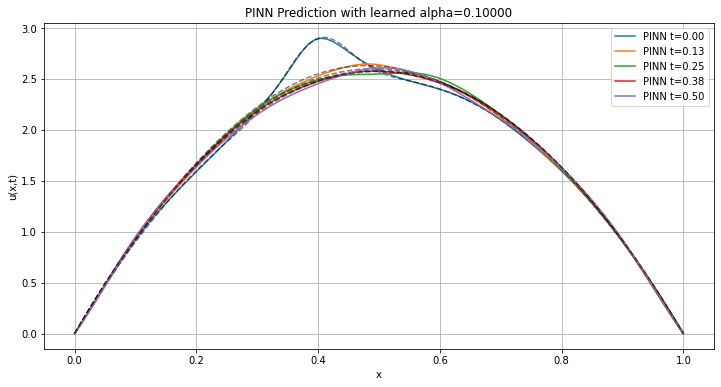

In [70]:

model.eval()

# Create a grid for plotting
x_plot = np.linspace(0, L, 100).reshape(-1,1).astype(np.float32)
t_plot = np.linspace(0, 0.5, 100).reshape(-1,1).astype(np.float32)
X, T = np.meshgrid(x_plot, t_plot)
x_grid = torch.tensor(X.flatten()[:,None], dtype=torch.float32)
t_grid = torch.tensor(T.flatten()[:,None], dtype=torch.float32)

# Predict with the trained PINN
u_pred = model(x_grid, t_grid).detach().numpy()
U_pred = u_pred.reshape(X.shape)

# True solution for comparison (if available)
U_true = u_xt(X, T)  # should return shape (100,100)

# Plot predictions vs true solution at several time slices
plt.figure(figsize=(12,6))

for i, ti in enumerate([0, 25, 50, 75, 99]):  # example time slices
    plt.plot(x_plot, U_pred[ti,:], label=f'PINN t={t_plot[ti,0]:.2f}')
    if U_true is not None:
        plt.plot(x_plot, U_true[ti,:], 'k--', alpha=0.5)

plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title(f'PINN Prediction with learned alpha={model.alpha.item():.5f}')
plt.legend()
plt.grid(True)
plt.show()
